[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/scalar_quantization/blob/master/LloydMax_quantization.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/scalar_quantization/blob/master/LloydMax_quantization.ipynb)

# Lloyd-Max quantization

* Minimizes the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) of the quantization error, i.e., the expectation of the power of the quantization error
\begin{equation}
 D = \text{E}[(\mathbf{x}-\mathbf{y})^2],
\end{equation}
where $D$ is the distortion generated by the quantizer, $\mathbf{x}$ is the original signal, and $\mathbf{y}$ is the reconstructed signal.
* The [PDF](https://en.wikipedia.org/wiki/Probability_density_function) (in the analog case) or the [histogram](https://en.wikipedia.org/wiki/Histogram) (digital signals) is required. The density of quantization bins is higher in those parts of the input dynamic range where the probability of the samples is also higher.
* The quantizer must determine the decision levels, and the representation levels, which are the centroid of each bin.

## Adaptive quantization using the PDF
In the continuous case, if $M$ is the number of bins, the distortion can be expressed by
\begin{equation}
D = \sum_{i=1}^{M}\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}(\mathbf{x}-\mathbf{c}_i)^2P(x)dx,
\end{equation}
where $\mathbf{b}_i$ is the upper decision level of the $i$-th bin, $\mathbf{c}_i$ is the representation level for the $i$-th bin, and $P(x)=f_\mathbf{x}(x)$ is the probability of finding $x$ in the signal (considered as a random variable) $\mathbf{x}$.

To minimize $D$ we must solve
\begin{equation}
\frac{\partial D}{\partial \mathbf{c}_i} = 0 = -\sum_{i=1}^M\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
which boilds down to
\begin{equation}
= -\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
because $\mathbf{c}_i$ is only used in one of the bins. We continue and therefore
\begin{equation}
= 2\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx - 2\mathbf{c}_i\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx.
\end{equation}
Solving,
\begin{equation}
\mathbf{c}_i = \frac{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx}{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx},\tag{1}
\end{equation}
i.e., the representation level $\mathbf{c}_i$ for each bin is the centroid of the probability mass in that bin. Notice that, in order to avoid a division by 0, at least one one sample must belong to each bin.

Unfortunately, such equation express that, to find the representation levels $\mathbf{c}_i$, we must determine first the decision levels $\mathbf{b}_i$. For computing them, we can now minimize $D$ respect to $\mathbf{b}_i$:
\begin{equation}
\frac{\partial D}{\partial \mathbf{b}_i} = 0,
\end{equation}
which, supposing that the bins are small enough to consider that the probability of the values of $\mathbf{x}$ is constant inside of each bin, ends up in that:
\begin{equation}
\mathbf{b}_i = \frac{\mathbf{c}_i+\mathbf{c}_{i+1}}{2},\tag{2}
\end{equation}
a result quite logical under such supposition.

## Computation of the representation levels.

Unfortunately, Equations (1) and (2) are mutually dependent. However, they can be used to compute $\{\mathbf{y}_k\}_{k=1}^M$ and $\{\mathbf{b}_k\}_{k=0}^M$ using the following iterative algorithm:

1. Initialize $\mathbf{c}_k$ /* centroids */ at random.
2. Let $\mathbf{previous\_b}=\{\mathbf{previous\_b}_k\}_{k=0}^M=0$ /* boundaries */.
2. While not reached some stopping criteria:
    1. $\mathbf{previous\_b}\leftarrow \mathbf{b}$.
    1. Compute the boundary (decision) levels $\mathbf{b}$ using Eq. (2).
    2. Update the centroids (representation levels) $\mathbf{c}$ using Eq. (1).

In [1]:
import numpy as np
from scipy.ndimage import uniform_filter1d
# from scipy.ndimage import center_of_mass

In [2]:
def compute_boundaries(c):
    b = uniform_filter1d(c, size=2, origin=-1)[:-1]
    b = np.concatenate(([0],b,[256]))
    print('b', b)
    return b

In [3]:
def compute_centroids(b, P, M):
    ended = False
    c = []
    bin_size = P.size//M
    print("bin_size", bin_size)
    for i in range(len(b) - 1):
        b_i = int(round(b[i]))    #i*bin_size
        b_i_1 = int(round(b[i+1]))#(i+1)*bin_size
        if b_i == b_i_1:
            ended = True
            break
        print("b_i", b_i, "b_i_1", b_i_1)
        # See from scipy.ndimage import center_of_mass
        mass = np.sum([j*P[j] for j in range(b_i, b_i_1)])
        total_counts_in_bin = np.sum([P[j] for j in range(b_i, b_i_1)])
        assert total_counts_in_bin > 0, f"bin [{b_i}, {b_i_1}] is not used (b={b})"
        centroid = mass/total_counts_in_bin
        c.append(centroid)
    return np.array(c), ended

In [4]:
def compute_levels(P, M, max_iters):
    total_count = np.sum(P)
    bin_count = total_count/M
    initial_boundaries = [0.]
    acc = 0
    counter = 0
    for p in P:
        acc += p
        counter += 1
        if acc > bin_count:
            initial_boundaries.append(float(counter))
            acc = 0
    initial_boundaries.append(256.)
    initial_boundaries = np.array(initial_boundaries)
    initial_centroids = 0.5 * (initial_boundaries[1:] + initial_boundaries[:-1])
    print("initial_centroids", initial_centroids, len(initial_centroids))
    c = initial_centroids
    b = initial_boundaries
    prev_b = np.zeros(b.size)
    for j in range(max_iters):
        prev_b[:] = b
        b = compute_boundaries(c)
        max_abs_error = np.max(np.abs(prev_b-b))
        print("max_abs_error", max_abs_error)
        prev_c = c
        c, ended = compute_centroids(b, P, M)
        if ended:
            break
    return b, prev_c

### Build a quantizer

In [5]:
P = np.ones(256) # Counts for uniform distribution
#P = np.random.randint(low=0, high=2000, size=256) # Counts for random distribution
max_iters = 100
M = 2
boundaries, centroids = compute_levels(P, M, max_iters)
print('boundaries', boundaries)
print('centroids', centroids)

initial_centroids [ 64.5 192.5] 2
b [  0.  128.5 256. ]
max_abs_error 0.5
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 1.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  

## Quantize an array that follows an uniform distribution

### Define the data to quantize

In [6]:
x = np.linspace(0, 255, 256)
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [7]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

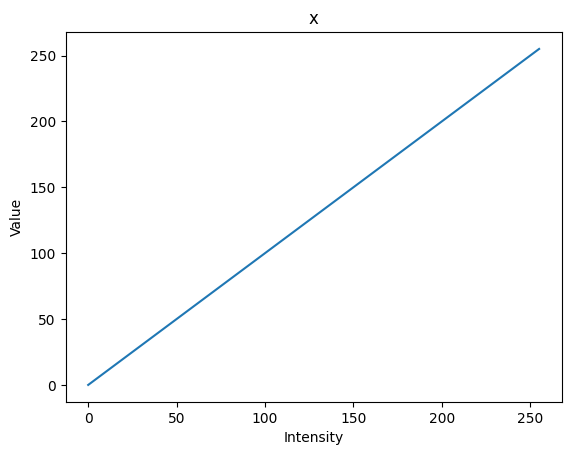

In [8]:
plt.figure()
plt.title("x")
plt.xlabel("Intensity")
plt.ylabel("Value")
plt.plot(x)

### Compute the histogram(x)

In [9]:
histogram_x, bin_edges_x = np.histogram(x, bins=256, range=(0, 256))
histogram_x

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

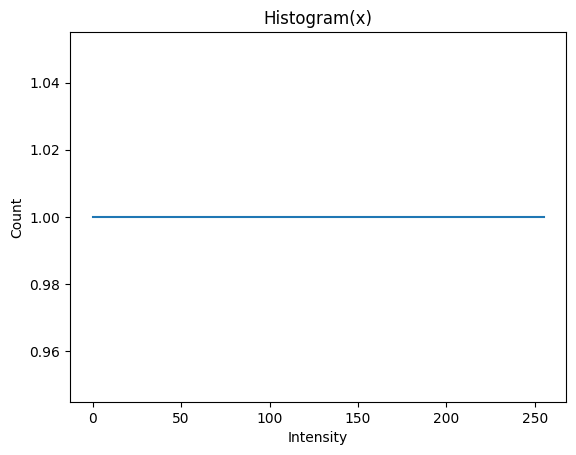

In [10]:
plt.figure()
plt.title("Histogram(x)")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges_x[0:-1], histogram_x)

### Encode(x)

In [11]:
k = np.searchsorted(boundaries, x, side="right") - 1
k

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

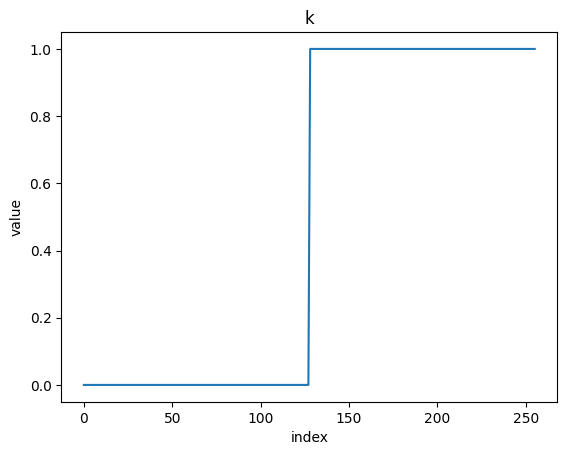

In [12]:
plt.figure()
plt.title("k")
plt.xlabel("index")
plt.ylabel("value")
plt.plot(k)

### Decode(k)

In [13]:
y = centroids[k]
y

array([ 63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,

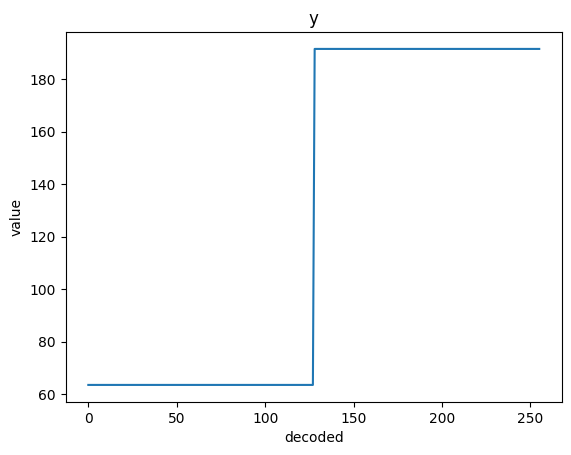

In [14]:
plt.figure()
plt.title("y")
plt.xlabel("decoded")
plt.ylabel("value")
plt.plot(y)

## Quantize an image

### Stuff for reading gray-scale images

In [15]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [ ]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

In [ ]:
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [ ]:
import image_1 as gray_image
import os

In [16]:
try:
    from skimage import io
    from skimage.color import rgb2gray
except:
    !pip install scikit-image
    from skimage import io
    from skimage.color import rgb2gray

In [17]:
#home = os.environ["HOME"]
#fn = home + "/repos/MRVC/images/lena_bw/"
#fn = home + "/repos/MRVC/images/circle/"
#fn = home + "/repos/MRVC/images/Hommer_bw/"
#!ls -l {fn}
fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"

### Read the image

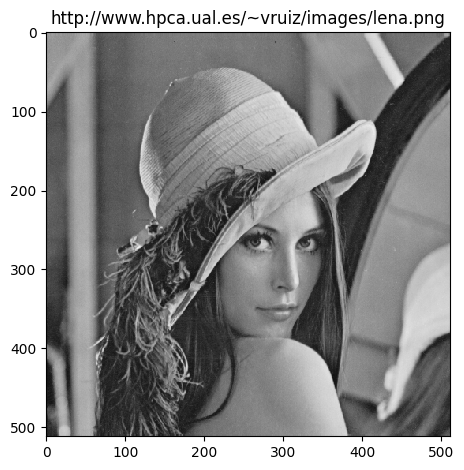

In [18]:
#img = gray_image.read(fn, 0)
#gray_image.show(img, fn + "000.png")
img = io.imread(fn)
img = (rgb2gray(img)*256).astype(np.uint8)
plt.figure()
plt.title(fn)
io.imshow(img)
plt.show()

### Histogram of the image

In [19]:
histogram_img, bin_edges_img = np.histogram(img, bins=256, range=(0, 256))
#histogram[histogram==0] = 1
print("histogram", histogram_img)
print("\bin_edges", bin_edges_img)
print(len(histogram_img))

histogram [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    3   17   24   57  104  138  171  265  324  434
  528  673  849  963 1119 1335 1450 1742 1762 1938 2038 1937 2026 2108
 1934 2062 1943 1757 1711 1706 1557 1456 1352 1248 1140 1029 1024  962
  926  823  841  838  793  872  855  832  853  953  868  928  927  908
  931  906  889  957  957  989  934  966 1100 1074 1152 1220 1240 1287
 1455 1510 1681 1830 1811 2078 1947 1876 1774 1803 1764 1680 1632 1556
 1511 1395 1353 1399 1361 1387 1365 1411 1405 1394 1443 1475 1562 1612
 1773 1854 2000 2066 2145 2225 2290 2219 2312 2087 2116 2063 1934 1832
 1827 1843 1819 1938 1890 1926 2005 2011 2136 2186 2139 2059 2086 2077
 2033 2071 2017 2089 2201 2290 2315 2395 2394 2515 2376 2351 2238 2069
 1839 1809 1716 1487 1368 1389 1311 1160 1169 1119 1082 1065 1163 1148
 1076 1125 1088  999 1090 1001  862  819  738  679  658  589  571  558
  564  574  619  601  666  631  720  791  780  850  921  932  819  

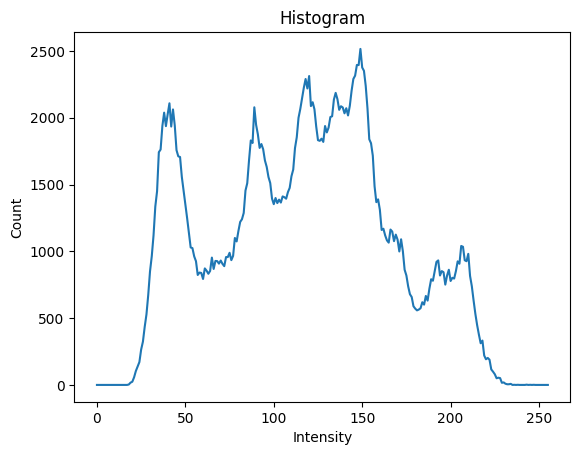

In [20]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges_img[0:-1], histogram_img)

### Build the quantizer

In [21]:
P = histogram_img
M = 128
boundaries_img, centroids_img = compute_levels(P, M, max_iters=100)

initial_centroids [ 14.5  30.5  33.   35.   37.   39.   41.   43.   45.   47.   49.   51.
  53.   55.5  58.5  61.5  64.5  67.5  70.5  73.5  76.5  79.   81.   83.
  85.   87.   89.   91.   93.   95.   97.   99.  101.  103.  105.  107.
 109.  111.  113.  115.  116.5 117.5 118.5 119.5 120.5 121.5 122.5 123.5
 125.  127.  129.  131.  133.  134.5 135.5 136.5 137.5 138.5 139.5 141.
 143.  144.5 145.5 146.5 147.5 148.5 149.5 150.5 151.5 152.5 153.5 155.
 157.  159.  161.  163.  165.  167.  169.  171.  173.  175.5 179.  183.
 187.  190.5 193.5 196.5 199.5 202.5 205.5 208.5 211.5 215.5 237. ] 95
b [  0.    22.5   31.75  34.    36.    38.    40.    42.    44.    46.
  48.    50.    52.    54.25  57.    60.    63.    66.    69.    72.
  75.    77.75  80.    82.    84.    86.    88.    90.    92.    94.
  96.    98.   100.   102.   104.   106.   108.   110.   112.   114.
 115.75 117.   118.   119.   120.   121.   122.   123.   124.25 126.
 128.   130.   132.   133.75 135.   136.   137.   138.   13

In [22]:
print(boundaries_img, len(boundaries_img))

[  0.          24.69840846  28.74562793  32.39567393  35.04495251
  36.75628773  38.51190216  40.49485243  42.239238    43.73743243
  45.48706661  47.72615194  50.21521122  52.72758236  55.47247962
  58.74326911  62.28261242  65.53376768  68.51046934  71.2588448
  73.75521605  76.26222185  78.78739889  81.27583376  83.50928722
  85.51524695  87.26060951  88.74186335  90.24186335  91.75202684
  93.49592928  95.73102736  98.23330396 100.74473221 103.25269582
 105.50316016 107.50175911 109.50667985 111.25393825 112.75947068
 114.25947068 115.75457666 117.25457666 118.5        119.5
 120.5        121.5        122.5        123.5        124.74965838
 126.75814052 129.00848214 130.75502417 132.25502417 133.75289218
 135.25289218 136.5        137.5        138.5        139.5
 140.74669765 142.24669765 143.75495435 145.25495435 146.5
 147.5        148.5        149.5        150.5        151.5
 152.5        153.5        154.5        155.73212613 157.48403038
 159.48662703 161.72181477 164.2480884 

In [23]:
print(centroids_img, len(centroids_img))

[ 22.60700389  26.78981302  30.70144284  34.08990501  36.
  37.51257545  39.51122887  41.478476    43.          44.47486486
  46.49926836  48.95303551  51.47738693  53.97777778  56.96718147
  60.51935676  64.04586808  67.02166728  69.9992714   72.5184182
  74.99201389  77.53242982  80.04236796  82.50929956  84.50927487
  86.52121903  88.          89.48372671  91.          92.50405368
  94.48780488  96.97424984  99.49235808 101.99710634 104.5082853
 106.49803501 108.50548321 110.5078765  112.         113.51894136
 115.         116.50915332 118.         119.         120.
 121.         122.         123.         124.         125.49931675
 128.01696429 130.         131.51004833 133.         134.50578436
 136.         137.         138.         139.         140.
 141.4933953  143.         144.50990871 146.         147.
 148.         149.         150.         151.         152.
 153.         154.         155.         156.46425226 158.50380849
 160.46944557 162.97418398 165.52199282 167.48381295

In [24]:
print(histogram_img)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    3   17   24   57  104  138  171  265  324  434
  528  673  849  963 1119 1335 1450 1742 1762 1938 2038 1937 2026 2108
 1934 2062 1943 1757 1711 1706 1557 1456 1352 1248 1140 1029 1024  962
  926  823  841  838  793  872  855  832  853  953  868  928  927  908
  931  906  889  957  957  989  934  966 1100 1074 1152 1220 1240 1287
 1455 1510 1681 1830 1811 2078 1947 1876 1774 1803 1764 1680 1632 1556
 1511 1395 1353 1399 1361 1387 1365 1411 1405 1394 1443 1475 1562 1612
 1773 1854 2000 2066 2145 2225 2290 2219 2312 2087 2116 2063 1934 1832
 1827 1843 1819 1938 1890 1926 2005 2011 2136 2186 2139 2059 2086 2077
 2033 2071 2017 2089 2201 2290 2315 2395 2394 2515 2376 2351 2238 2069
 1839 1809 1716 1487 1368 1389 1311 1160 1169 1119 1082 1065 1163 1148
 1076 1125 1088  999 1090 1001  862  819  738  679  658  589  571  558
  564  574  619  601  666  631  720  791  780  850  921  932  819  852
  844 

### Encode

In [25]:
indexes_img = np.searchsorted(boundaries_img, img) - 1

In [26]:
print(indexes_img.shape)
print(np.min(indexes_img))
print(np.max(indexes_img))
print(np.unique(indexes_img))
print(len(np.unique(indexes_img)))

(512, 512)
0
94
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
95


/home/vruiz/enviroments/SM/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


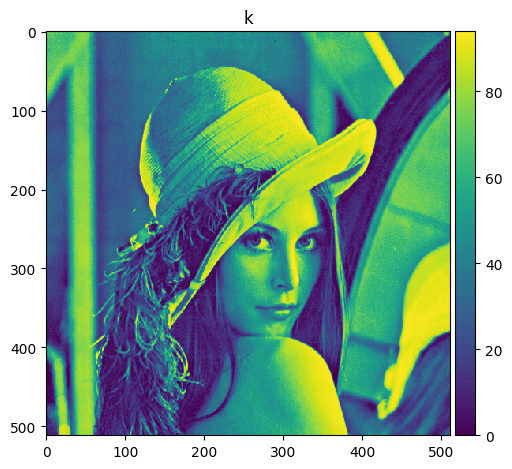

In [27]:
#gray_image.show_normalized(indexes_img, "k")
plt.figure()
plt.title('k')
io.imshow(indexes_img)
plt.show()

### Decode

In [28]:
decoded_img = centroids_img[indexes_img]#.astype(np.uint8)

In [29]:
print(decoded_img.min(), decoded_img.max())

22.607003891050585 224.82319660537482


In [ ]:
#gray_image.show(decoded_img, "decoded")
plt.figure()
plt.title("decoded")
io.imshow(decoded_img)
plt.show()

## Quantization function

In [ ]:
x = np.linspace(0, 255, 256) # Input samples
x

In [ ]:
indexes_x = np.searchsorted(boundaries_img, x) - 1
indexes_x

In [ ]:
decoded_x = centroids_img[indexes_x]#.astype(np.uint8)
decoded_x

In [ ]:
xlabel = "Input Sample"
ylabel = "Reconstructed Sample"
title = f"Lloyd-Max Quantizer ({fn}, $\M={M}$)"

ax1 = plt.subplot()
counts, bins = np.histogram(img, range(256))
l1 = ax1.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
ax2 = ax1.twinx()
l2, = ax2.plot(x[1:], decoded_x[1:], color='m')

plt.title("Histogram VS Quantization Function")
plt.legend([l1, l2], ["Histogram", "Lloyd-Max Quantizer"])
ax1.yaxis.set_label_text("Pixel Value Count")
ax2.yaxis.set_label_text("Reconstructed Value")
ax1.xaxis.set_label_text("Input Sample")
plt.show()

## Testing the library

In [ ]:
import LloydMax_quantization as quantization

In [ ]:
Q_step = 128
quantizer = quantization.LloydMax_Quantizer
Q = quantizer(Q_step=Q_step, counts=histogram_img)
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

In [ ]:
#quantized_img, indexes = Q.encode_and_decode(img.flatten())
quantized_img, indexes = Q.encode_and_decode(img)

In [ ]:
#gray_image.show_normalized(indexes.reshape(img.shape), fn + "000.png")
#gray_image.show(quantized_img, "y")
gray_image.show(quantized_img, "y")